# Building A Handritten Digits Classifier

In this project I will build a model that can classify handwritten digits.  I will explore the effectiveness of deep, feedforward neural networks at classifying images.


## Importing Data

In [1]:
# Scikit-learn contains a number of datasets pre-loaded
# This function returns a copy of the hand_written digits dataset
from sklearn.datasets import load_digits

#Additional necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [2]:
image = load_digits()
image.keys()

dict_keys(['target_names', 'DESCR', 'data', 'target', 'images'])

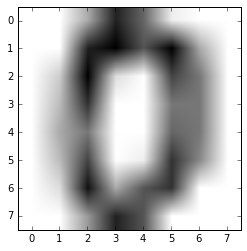

In [3]:
image_df = pd.DataFrame(image.data)
labels = pd.Series(image.target)
image_one = image_df.iloc[0]
np_image = image_one.values
np_image = np_image.reshape(8,8)
plt.imshow(np_image,cmap='gray_r')


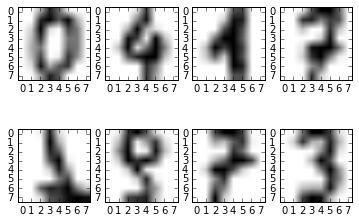

In [4]:
#choosing values to visualize
vis = [0,100,200,300,1000,1100,1200,1300]
fig, ax = plt.subplots(nrows=2, ncols=4)
#visualizing selected values
i = 0
for row in ax:
    for col in row:
        col.imshow(image_df.iloc[vis[i]].values.reshape(8,8),cmap='gray_r')
        i += 1


In [5]:
#Actual labels of the above data
print(labels[vis].values)

[0 4 1 7 1 9 7 3]


# Training K-Nearest Neighbors Model

Linear and logistic regression models assume linearity between features and output labels within a dataset.  For our purposes, we cannot assume linearity within the data.  The K-Nearest Neighbors algorithm does not assume linearity.  K-nearest neighbors don't have a specific model representation (hence why it's referred to as an algorithm and not a model).

The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
def train(k,train_df,train_labels):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_df,train_labels)
    return knn
def test(model,test_df,test_labels):
    prediction = model.predict(test_df)
    return accuracy_score(y_true=test_labels,y_pred=prediction)
    
def cross_validate(k):
    index_split = np.round(np.linspace(0,len(labels),5)).astype(int)
    accuracies = []
    for i in range(4):
        split = image_df.index.isin(np.arange(index_split[i],index_split[i+1]))
        train_df = image_df[~split]
        train_labels = labels[~split]
        test_df = image_df[split]
        test_labels = labels[split]
        model = train(k,train_df,train_labels)
        accuracies.append(test(model,test_df,test_labels))
    return np.mean(accuracies)

mean_accuracy = cross_validate(5)
print(mean_accuracy)    

0.9621529324424647


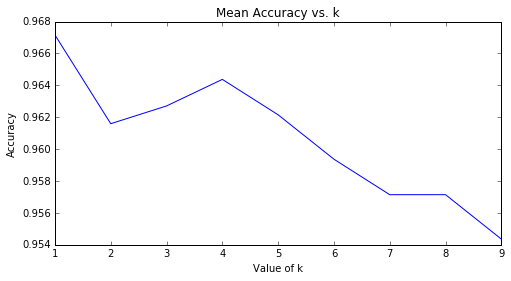

In [8]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.xlabel('Value of k')
plt.ylabel('Accuracy')
plt.plot(k_values, k_overall_accuracies)

The K-Nearest Neighbors algorithm achieved a surprisingly accurate result.  There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

Let's now try a neural network with a single hidden layer. Use the MLPClassifier package from scikit-learn.

# Neural Network With One Hidden Layer

I will use the MLPClassifier package from scikit-learn to model a neural network.

In [9]:
def train(layer,train_df,train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=layer)
    mlp.fit(train_df,train_labels)
    return mlp

def test(model,test_df,test_labels):
    predictions = model.predict(test_df)
    return accuracy_score(y_true=test_labels,y_pred=predictions)

def nn_cross_validate(layer):
    kf = KFold(n_splits=4, random_state=2)
    accuracies = []

    for train_index, test_index in kf.split(image_df):
        
        train_df = image_df.loc[train_index]
        train_labels = labels.iloc[train_index]
            
        test_df = image_df.loc[test_index]
        test_labels = labels.iloc[test_index]
            
        model = train(layer,train_df,train_labels)
        accuracy = test(model,test_df,test_labels)
        accuracies.append(accuracy)
        

    return accuracies



In [10]:
nn_layers = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]

In [11]:
accuracies = []
for n in nn_layers:
    acc = nn_cross_validate(n)
    means = np.mean(acc)
    accuracies.append(means)
    
    


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



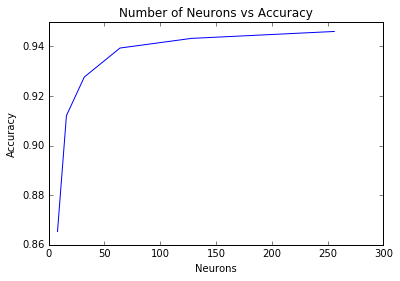

In [12]:
accuracies
number_neurons = [8,16,32,64,128,256]

plt.plot(number_neurons,accuracies)
plt.title('Number of Neurons vs Accuracy')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.figure(figsize=(8,4))

# Summary

Adding more neurons appears to increase the accuracy for classification.  Accuracy increased from around 76% to around 95%.  Although, since K-Nearest Neighbor found an accuracy around 96% there doesn't seem to be an advantage to using a single layer mlp.

# Neural Network With Two Hidden Layers

Adding more neurons to a single hidden layer vastly improved the classification accuracy.  Now I will try using two hidden layers and continue to increase the number of neurons in each layer

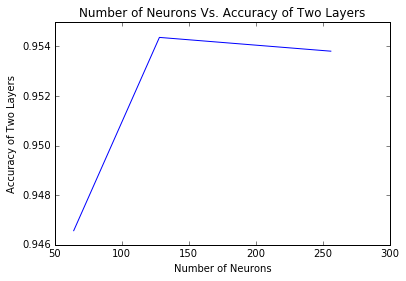

In [13]:
nn_two_layers = [
    (64,64),
    (128,128),
    (256,256)
]
two_layer_accuracy = []
num_neuron = []
for n in nn_two_layers:
    acc = nn_cross_validate(n)
    means = np.mean(acc)
    two_layer_accuracy.append(means)
    num_neuron.append(n[0])
    
plt.plot(num_neuron,two_layer_accuracy)
plt.title('Number of Neurons Vs. Accuracy of Two Layers')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy of Two Layers')
    


# Summary 

Using 2 hidden layers improved our simple accuracy to 95%. Using 4-fold Cross Validation appears to cause overfitting past 128 neurons.  Using 4-fold cross validation also gives me a bit more assurance that the model is generalizing to achieve the extra 1% in simple accuracy over the single hidden layer networks we tried earlier.

# Neural Network With Three Hidden Layers

Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

In [ ]:
def train(layer,train_df,train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=layer)
    mlp.fit(train_df,train_labels)
    return mlp

def test(model,test_df,test_labels):
    predictions = model.predict(test_df)
    return accuracy_score(y_true=test_labels,y_pred=predictions)

def nn_cross_validate(layer):
    kf = KFold(n_splits=6, random_state=2)
    accuracies = []

    for train_index, test_index in kf.split(image_df):
        
        train_df = image_df.loc[train_index]
        train_labels = labels.iloc[train_index]
            
        test_df = image_df.loc[test_index]
        test_labels = labels.iloc[test_index]
            
        model = train(layer,train_df,train_labels)
        accuracy = test(model,test_df,test_labels)
        accuracies.append(accuracy)
        

    return accuracies



In [ ]:
nn_three_layers = [
    (10,10,10),
    (64,64,64),
    (128,128,128)
]
three_layer_accuracy = []
num_neuron = []
for n in nn_three_layers:
    acc = nn_cross_validate(n)
    means = np.mean(acc)
    three_layer_accuracy.append(means)
    num_neuron.append(n[0])
    
plt.plot(num_neuron,three_layer_accuracy)
plt.title('Number of Neurons Vs. Accuracy of Three Layers')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy of Three Layers')